<a href="https://colab.research.google.com/github/denizsen97/Ensemble-Adversarial-Training-with-Tensorflow-2.0/blob/master/EnsembleAdversairalTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# Define Model

Define a reursable model class as there are many model creation and usage of these models in different parts

In [ ]:
class AdvModel:
  def __init__(self, name, load_file_name=None, show_summary=True):
    self.name = name
    self.directory = "/content/gdrive/My Drive/Mmi 2nd semester/Deep Learning/Project/Model" + self.name + "/"

    if load_file_name is not None:
      self.model = keras.models.load_model(self.directory + load_file_name + ".h5")
    else:
      self.model = keras.models.Sequential()
      input_layer = layers.InputLayer(input_shape=[28, 28, 1])
      self.model.add(input_layer)
      if name is "A":
        self.model.add(layers.Conv2D(64, 5, activation='relu', padding='same' ))
        self.model.add(layers.Conv2D(64, 5, activation='relu', padding='same'))
        self.model.add(layers.Dropout(0.25))
        self.model.add(layers.Flatten())
        self.model.add(layers.Dense(128, activation='relu'))
        self.model.add(layers.Dropout(0.5))
        self.model.add(layers.Dense(10, activation='softmax'))
      elif name is "B":
        self.model.add(layers.Dropout(0.2))
        self.model.add(layers.Conv2D(64, 8, activation='relu', padding='same'))
        self.model.add(layers.Conv2D(128, 6, activation='relu', padding='same'))
        self.model.add(layers.Conv2D(128, 5, activation='relu', padding='same'))
        self.model.add(layers.Dropout(0.5))
        self.model.add(layers.Flatten())
        self.model.add(layers.Dense(10, activation='softmax'))
      elif name is "C":
        self.model.add(layers.Conv2D(128, 3, activation='tanh', padding='same' ))
        self.model.add(layers.MaxPool2D(pool_size=(2, 2)))
        self.model.add(layers.Conv2D(64, 3, activation='tanh', padding='same'))
        self.model.add(layers.MaxPool2D(pool_size=(2, 2)))
        self.model.add(layers.Flatten())
        self.model.add(layers.Dense(128, activation='relu'))
        self.model.add(layers.Dense(10, activation='softmax'))
      elif name is "D":
        self.model.add(layers.Flatten())
        self.model.add(layers.Dense(300, activation='relu'))
        self.model.add(layers.Dropout(0.5))
        self.model.add(layers.Dense(300, activation='relu'))
        self.model.add(layers.Dropout(0.5))
        self.model.add(layers.Dense(300, activation='relu'))
        self.model.add(layers.Dropout(0.5))
        self.model.add(layers.Dense(300, activation='relu'))
        self.model.add(layers.Dropout(0.5))
        self.model.add(layers.Dense(10, activation='softmax'))
      else:
        print("Invalid Model Name!")
        return

      self.model.compile(optimizer='adam', loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
    if show_summary:
      self.model.summary()
  
  def get_signed_gradient(self, input_image, input_label, loss_object=keras.losses.CategoricalCrossentropy()):
    with tf.GradientTape() as tape:
      tape.watch(input_image)
      prediction = self.model(input_image)
      loss = loss_object(input_label, prediction)
    gradient = tape.gradient(loss, input_image)
    signed_grad = tf.sign(gradient)
    return signed_grad

  def fgsm(self, input_image, input_label, iteration_number=1, epsilon=0.3, alpha=None):
    cur_image = input_image
    for i in range(iteration_number):
      if alpha is not None:
        assert alpha < epsilon
        cur_image = cur_image + alpha * np.random.rand(input_image.shape[0], input_image.shape[1], input_image.shape[2], input_image.shape[3])
      signed_grad = self.get_signed_gradient(tf.convert_to_tensor(cur_image), tf.convert_to_tensor(input_label))
      if alpha is None:
        cur_image = cur_image + signed_grad * (epsilon/iteration_number)
      else:
        cur_image = cur_image + signed_grad * ((epsilon - alpha)/iteration_number)
      cur_image = np.clip(cur_image, 0.0, 1.0)
    return cur_image, input_label


  def accuracy(self, true_label, prediction):
    return np.sum(np.argmax(true_label, axis=1) == np.argmax(prediction, axis=1)) / prediction.shape[0]

  def adversarial_training(self, x, y, fgsm_iteration=1, epsilon=0.3, batch_size=100, epoch_no=12, save_file_name=None):
    assert x.shape[0] == y.shape[0]
    for epoch in range(epoch_no):
      loss_iter = []
      acc_iter = []
      for i in range(x.shape[0]//batch_size):
        batch_x = x[i * batch_size:(i+1)*batch_size, :, :, :]
        batch_y = y[i * batch_size:(i+1)*batch_size, :]

        adv_batch_x, _ = self.fgsm(batch_x, batch_y, iteration_number=fgsm_iteration, epsilon=epsilon)

        batch_x = np.concatenate((batch_x, adv_batch_x))
        batch_y = np.concatenate((batch_y, batch_y))

        hist = self.model.fit(batch_x, batch_y, batch_size=batch_size, verbose=0, epochs=1)
        loss_iter.append(hist.history['loss'])
        acc_iter.append(hist.history['accuracy'])
      print("Epoch {}-> Loss:{} Accuracy:{}".format(epoch+1, np.mean(loss_iter), np.mean(acc_iter)))
    
    if save_file_name is not None:
      import os
      if not os.path.exists(self.directory):
        os.makedirs(self.directory)
      self.model.save(self.directory + save_file_name + ".h5")

  def adversarial_attack(self, x, y, fgsm_iteration=1, epsilon=0.3, alpha=None, random=None, batch_size=100, loss_object=keras.losses.CategoricalCrossentropy()):
    losses = []
    accs = []
    for i in tqdm(range(x.shape[0] // batch_size)):
      batch_x = x[i * batch_size:(i+1)*batch_size, :, :, :]
      batch_y = y[i * batch_size:(i+1)*batch_size, :]

      x_adv, _ = self.fgsm(batch_x, batch_y, iteration_number=fgsm_iteration, epsilon=epsilon, alpha=alpha) 

      predictions = self.model.predict(x_adv)
      loss = loss_object(batch_y, predictions)

      p = np.argmax(predictions, axis=1)
      b = np.argmax(batch_y, axis=1)

      correct_num = np.sum(np.argmax(predictions, axis=1) == np.argmax(batch_y, axis=1))
      acc = correct_num / predictions.shape[0]
      losses.append(loss)
      accs.append(acc)

    return np.mean(accs), np.mean(losses)

  def train(self, x_train, y_train, x_test, y_test, batch_size=100, epoch=6, save_file_name=None):
    #cp_callback = keras.callbacks.ModelCheckpoint(filepath=directory + "cp.ckpt", save_weights_only=True, verbose=0, save_freq=epoch)
    history = self.model.fit(x_train, y_train, epochs=epoch, validation_data=(x_test, y_test), batch_size=100)
    if save_file_name is not None:
      import os
      if not os.path.exists(self.directory):
        os.makedirs(self.directory)
      self.model.save(self.directory + save_file_name + ".h5")

  #TODO:ya pgd eklenecek yada yeni fonksiyon yazılacak
  def generate_adversarial_examples(self, x, y, fgsm_iteration=1, batch_size=100, epsilon=0.3, save_adversarial_images=None):

    adv_examples = np.zeros(shape=x.shape)
    
    for i in tqdm(range(x.shape[0] // batch_size)):
      batch_x = x[i * batch_size:(i+1)*batch_size, :, :, :]
      batch_y = y[i * batch_size:(i+1)*batch_size, :]

      x_adv, _ = self.fgsm(batch_x, batch_y, iteration_number=fgsm_iteration, epsilon=epsilon) 

      adv_examples[i * batch_size:(i+1)*batch_size, :, :, :] = x_adv

    if save_adversarial_images is not None:
      np.save(self.directory + save_adversarial_images + "_x.npy", adv_examples)
      np.save(self.directory + save_adversarial_images + "_y.npy", y)

    return adv_examples, y

  def evaluate(self, x, y):
    prediction = self.model.predict(x)
    loss_object=keras.losses.CategoricalCrossentropy()
    loss = loss_object(y, prediction)
    return prediction, self.accuracy(y, prediction), loss


# Fetch and preprocess the data

In [ ]:
mnist = keras.datasets.mnist;

(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(y_train[0])

x_train = np.asarray(x_train).reshape((-1, 28, 28, 1))
x_test = np.asarray(x_test).reshape((-1, 28, 28, 1))

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)
print(y_test)

x_train, x_test = x_train / 255.0, x_test / 255.0


11493376/11490434 [==============================] - 0s 0us/step
5
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
model = AdvModel("A")
model.train(x_train, y_train, x_test, y_test, epoch=1)
im, label = model.fgsm(x_test[:10], y_test[0:10])
p, a, _ = model.evaluate(im, label)




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 64)        1664      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        102464    
_________________________________________________________________
dropout_2 (Dropout)          (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               6422656   
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

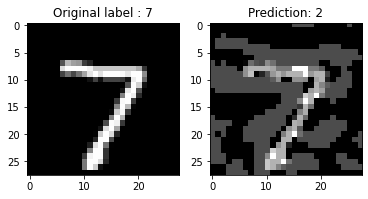

In [ ]:

f = plt.figure()
f.add_subplot(1,2, 1)
plt.title("Original label : 7")
plt.imshow(np.squeeze(x_test[0]), cmap='gray')
f.add_subplot(1,2, 2)
plt.title("Prediction: {}".format(np.argmax(p[0])))
plt.imshow(np.squeeze(im[0]), cmap='gray')
plt.savefig("prediction.jpg")
plt.show(block=True)




100%|██████████| 1/1 [00:00<00:00, 21.32it/s]


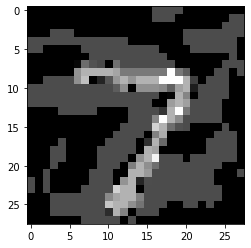

In [ ]:
im, y = model.generate_adversarial_examples(x_test[0:100], y_test[0:100])
plt.figure()
plt.imshow(np.squeeze(im[0]), cmap='gray')
plt.show()

# Regularly Train Models

In [ ]:
TRAIN_FILE_NAME = "regular_train"
ADVERSARIAL_EXAMPLE_FILE_NAME = "adversarial_examples"
ADVERSARIAL_EXAMPLE_PGD_FILE_NAME = "pgd_adversarial_examples"
ADVERSARIAL_EXAMPLE_TRAIN_FILE_NAME = "train_adversarial"
PERTURBATIONS_FILE_NAME = "perturbations"

ADVERSARIAL_TRAINED_MODEL = "adversarial_model"
ENSEMBLE_TRAINED_MODEL = "all_ensemble_model"
SAME_ENSEMBLE_TRAINED_MODEL = "same_ensemble_model"

def getDirectory(name):
  return "/content/gdrive/My Drive/Mmi 2nd semester/Deep Learning/Project/Model" + name + "/"
model_names = ["A", "B", "C", "D"]

In [ ]:
for model_name in model_names:
  print("Model " + model_name)
  model = AdvModel(name=model_name)
  #train and save the file
  model.train(x_train, y_train, x_test, y_test, save_file_name=TRAIN_FILE_NAME)
  #whitebox attack
  accuracy, loss = model.adversarial_attack(x_test, y_test)
  print("\nWhite-box adversarial attack Accuracy {}, Loss {}".format(accuracy, loss))
  
  model.generate_adversarial_examples(x_train, y_train, fgsm_iteration=1, save_adversarial_images=ADVERSARIAL_EXAMPLE_TRAIN_FILE_NAME)
  print("Saved train set FGSM adversarial examples generated by " + model_name)
  model.generate_adversarial_examples(x_test, y_test, fgsm_iteration=1, save_adversarial_images=ADVERSARIAL_EXAMPLE_FILE_NAME)
  print("Saved test set FGSM adversarial examples generated by " + model_name)
  model.generate_adversarial_examples(x_test, y_test, fgsm_iteration=16, save_adversarial_images=ADVERSARIAL_EXAMPLE_PGD_FILE_NAME)
  print("Saved test set PGD adversarial examples generated by " + model_name)
  
  print("Saved adversarial examples and perturbations")



Model A
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        102464    
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               6422656   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)         

100%|██████████| 100/100 [00:03<00:00, 26.37it/s]



White-box adversarial attack Accuracy 0.4841000000000001, Loss 2.8142621517181396
Saved adversarial examples and perturbations
Model B
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_2 (Dropout)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        4160      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       295040    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 128)       409728    
_________________________________________________________________
dropout_3 (Dropout)          (None, 28, 28, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)       

100%|██████████| 100/100 [00:06<00:00, 16.25it/s]



White-box adversarial attack Accuracy 0.1407, Loss 4.599803447723389
Saved adversarial examples and perturbations
Model C
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 128)       1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               401536  

100%|██████████| 100/100 [00:03<00:00, 28.11it/s]



White-box adversarial attack Accuracy 0.4010000000000001, Loss 9.310108184814453
Saved adversarial examples and perturbations
Model D
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 300)               235500    
_________________________________________________________________
dropout_4 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_5 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 300)           

100%|██████████| 100/100 [00:03<00:00, 30.68it/s]


White-box adversarial attack Accuracy 0.0871, Loss 5.4871015548706055
Saved adversarial examples and perturbations


## Adversarial black-box attack

In [ ]:
for i in range(len(model_names)):
  model_name = model_names[i]
  print("Model " + model_name)
  model = AdvModel(model_name, load_file_name=TRAIN_FILE_NAME)

  accuracy, loss = model.adversarial_attack(x_test, y_test, alpha=0.15)
  print("White-box R+FGSM adversarial attack Accuracy {}, Loss {}".format(accuracy, loss))

  accuracy, loss = model.adversarial_attack(x_test, y_test)
  print("White-box FGSM adversarial attack Accuracy {}, Loss {}".format(accuracy, loss))

  for j in range(len(model_names)):
    if i is j:
      continue
    attack_model_name = model_names[j]
    dataX = np.load(getDirectory(attack_model_name) + ADVERSARIAL_EXAMPLE_FILE_NAME + "_x.npy")
    dataY = np.load(getDirectory(attack_model_name) + ADVERSARIAL_EXAMPLE_FILE_NAME + "_y.npy")
    _, accuracy, loss = model.evaluate(dataX, dataY)
    print("Block-box adversarial attack from Model " + attack_model_name + " Accuracy {}, Loss {}".format(accuracy, loss))

Model A


  1%|          | 1/100 [00:00<00:12,  8.03it/s]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        102464    
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               6422656   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

  2%|▏         | 2/100 [00:00<00:07, 13.82it/s]

White-box R+FGSM adversarial attack Accuracy 0.4157, Loss 2.3670573234558105


100%|██████████| 100/100 [00:07<00:00, 13.37it/s]


White-box FGSM adversarial attack Accuracy 0.4837000000000002, Loss 2.818249225616455
Block-box adversarial attack from Model B Accuracy 0.3242, Loss 4.204250335693359
Block-box adversarial attack from Model C Accuracy 0.4385, Loss 4.245081901550293


KeyboardInterrupt: ignored

In [ ]:
for i in range(len(model_names)):
  model_name = model_names[i]
  print("Model " + model_name)
  model = AdvModel(model_name)
  model.adversarial_training(x_train, y_train)

  accuracy, loss = model.adversarial_attack(x_test, y_test, alpha=0.15)
  print("White-box R+FGSM adversarial attack Accuracy {}, Loss {}".format(accuracy, loss))

  accuracy, loss = model.adversarial_attack(x_test, y_test)
  print("White-box FGSM adversarial attack Accuracy {}, Loss {}".format(accuracy, loss))

  for j in range(len(model_names)):
    attack_model_name = model_names[j]
    dataX = np.load(getDirectory(attack_model_name) + ADVERSARIAL_EXAMPLE_FILE_NAME + "_x.npy")
    dataY = np.load(getDirectory(attack_model_name) + ADVERSARIAL_EXAMPLE_FILE_NAME + "_y.npy")
    _, accuracy, loss = model.evaluate(dataX, dataY)
    print("Block-box adversarial attack from Model " + attack_model_name + " Accuracy {}, Loss {}".format(accuracy, loss))

Model A
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 28, 28, 64)        1664      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 28, 28, 64)        102464    
_________________________________________________________________
dropout_18 (Dropout)         (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               6422656   
_________________________________________________________________
dropout_19 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 10)       

  1%|          | 1/100 [00:00<00:10,  9.20it/s]

Epoch 12-> Loss:0.021828279847195518 Accuracy:0.9929833396275838


  2%|▏         | 2/100 [00:00<00:07, 13.59it/s]

White-box R+FGSM adversarial attack Accuracy 0.6689000000000002, Loss 2.7534258365631104


100%|██████████| 100/100 [00:07<00:00, 13.21it/s]


White-box FGSM adversarial attack Accuracy 0.9972, Loss 0.012402910739183426
Block-box adversarial attack from Model A Accuracy 0.6931, Loss 4.81382417678833
Block-box adversarial attack from Model B Accuracy 0.3064, Loss 10.84823226928711
Block-box adversarial attack from Model C Accuracy 0.4305, Loss 8.979379653930664
Block-box adversarial attack from Model D Accuracy 0.4947, Loss 6.457332134246826
Model B
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_20 (Dropout)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 28, 28, 64)        4160      
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 28, 28, 128)       295040    
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 2

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 12-> Loss:0.030573874848147775 Accuracy:0.9902000079552332


  1%|          | 1/100 [00:00<00:15,  6.19it/s]

White-box R+FGSM adversarial attack Accuracy 0.569, Loss 2.297996759414673


100%|██████████| 100/100 [00:16<00:00,  5.91it/s]


White-box FGSM adversarial attack Accuracy 0.9833, Loss 0.06012984365224838
Block-box adversarial attack from Model A Accuracy 0.739, Loss 3.056544542312622
Block-box adversarial attack from Model B Accuracy 0.5463, Loss 4.576071739196777
Block-box adversarial attack from Model C Accuracy 0.5661, Loss 4.799777030944824
Block-box adversarial attack from Model D Accuracy 0.6549, Loss 2.7576112747192383
Model C
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 28, 28, 128)       1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 14, 14, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7

  1%|          | 1/100 [00:00<00:17,  5.69it/s]

Epoch 12-> Loss:0.017379668544703956 Accuracy:0.9944750049710274


  2%|▏         | 2/100 [00:00<00:07, 13.41it/s]

White-box R+FGSM adversarial attack Accuracy 0.24960000000000002, Loss 9.788789749145508


100%|██████████| 100/100 [00:07<00:00, 13.32it/s]


White-box FGSM adversarial attack Accuracy 0.9948, Loss 0.018403736874461174
Block-box adversarial attack from Model A Accuracy 0.7752, Loss 1.3292542695999146
Block-box adversarial attack from Model B Accuracy 0.6016, Loss 2.186602830886841
Block-box adversarial attack from Model C Accuracy 0.7989, Loss 0.977613091468811
Block-box adversarial attack from Model D Accuracy 0.6667, Loss 1.883243203163147
Model D
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_12 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 300)               235500    
_________________________________________________________________
dropout_22 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_24 (Dense)             (None,

  2%|▏         | 2/100 [00:00<00:06, 14.33it/s]

Epoch 12-> Loss:0.7442305644353231 Accuracy:0.7759333324432373


  3%|▎         | 3/100 [00:00<00:04, 22.49it/s]

White-box R+FGSM adversarial attack Accuracy 0.045899999999999996, Loss 4.088164806365967


100%|██████████| 100/100 [00:04<00:00, 21.52it/s]


White-box FGSM adversarial attack Accuracy 0.6244999999999999, Loss 1.1845892667770386
Block-box adversarial attack from Model A Accuracy 0.7526, Loss 1.2041257619857788
Block-box adversarial attack from Model B Accuracy 0.4106, Loss 2.0555334091186523
Block-box adversarial attack from Model C Accuracy 0.5878, Loss 2.1227171421051025
Block-box adversarial attack from Model D Accuracy 0.5696, Loss 2.2944037914276123


# Adversarial Training

# Adversarial Training with perturbations of another model with the same architecture

## First create a random black-box attack data set from the previously generated adversarial examples

In [ ]:
from sklearn.model_selection import train_test_split 

bb_fgms_x = None
bb_fgsm_y = None

for model_name in model_names:
  x_data = np.load(getDirectory(model_name) + ADVERSARIAL_EXAMPLE_FILE_NAME + "_x.npy")
  y_data = np.load(getDirectory(model_name) + ADVERSARIAL_EXAMPLE_FILE_NAME + "_y.npy")
  
  x_split, _, y_split, _ = train_test_split(x_data, y_data, test_size=0.75, random_state=42)
  if bb_fgms_x is None:
    bb_fgms_x = x_split
    bb_fgsm_y = y_split
  else:
    bb_fgms_x = np.concatenate((bb_fgms_x, x_split))
    bb_fgsm_y = np.concatenate((bb_fgsm_y, y_split))

bb_pgd_x = None
bb_pgd_y = None

for model_name in model_names:
  x_data = np.load(getDirectory(model_name) + ADVERSARIAL_EXAMPLE_PGD_FILE_NAME + "_x.npy")
  y_data = np.load(getDirectory(model_name) + ADVERSARIAL_EXAMPLE_PGD_FILE_NAME + "_y.npy")
  
  x_split, _, y_split, _ = train_test_split(x_data, y_data, test_size=0.75, random_state=42)
  if bb_pgd_x is None:
    bb_pgd_x = x_split
    bb_pgd_y = y_split
  else:
    bb_pgd_x = np.concatenate((bb_pgd_x, x_split))
    bb_pgd_y = np.concatenate((bb_pgd_y, y_split))

print(bb_pgd_x.shape)


(10000, 28, 28, 1)


## Adversarial training with single step FGSM attack

In [ ]:
for model_name in model_names:
  model = AdvModel(model_name)
  model.adversarial_training(x_train, y_train, epoch_no=12)

  _, clean_acc, clean_loss = model.evaluate(x_test, y_test)
  print("Model " + model_name + ": On Clean Data Accuracy:{} Loss:{}".format(clean_acc, clean_loss))

  wb_acc, wb_loss = model.adversarial_attack(x_test, y_test)
  print("Model " + model_name + ": On White-box FGSM Attack Accuracy:{} Loss:{}".format(wb_acc, wb_loss))
  
  _, bb_fgsm_acc, bb_fgsm_loss = model.evaluate(bb_fgms_x, bb_fgsm_y)
  print("Model " + model_name + ": On Black-box FGSM Attack Accuracy:{} Loss:{}".format(bb_fgsm_acc, bb_fgsm_loss))

  _, bb_pgd_acc, bb_pgd_loss = model.evaluate(bb_pgd_x, bb_pgd_y)
  print("Model " + model_name + ": On Black-box PGD Attack Accuracy:{} Loss:{}".format(bb_pgd_acc, bb_pgd_loss))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 64)        1664      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        102464    
_________________________________________________________________
dropout_2 (Dropout)          (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               6422656   
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

  2%|▏         | 2/100 [00:00<00:06, 15.43it/s]

Model A: On Clean Data Accuracy:0.9914 Loss:0.03729674965143204


100%|██████████| 100/100 [00:06<00:00, 14.51it/s]


Model A: On White-box FGSM Attack Accuracy:0.9821000000000002 Loss:0.06619900465011597
Model A: On Black-box FGSM Attack Accuracy:0.5521 Loss:6.350437641143799
Model A: On Black-box PGD Attack Accuracy:0.9549 Loss:0.17236828804016113
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_4 (Dropout)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 64)        4160      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 128)       295040    
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 128)       409728    
_________________________________________________________________
dropout_5 (Dropout)          (None, 28, 28, 128)       0         
__________________

  1%|          | 1/100 [00:00<00:16,  5.91it/s]

Model B: On Clean Data Accuracy:0.9892 Loss:0.031647223979234695


100%|██████████| 100/100 [00:16<00:00,  5.94it/s]


Model B: On White-box FGSM Attack Accuracy:0.978 Loss:0.08080042153596878
Model B: On Black-box FGSM Attack Accuracy:0.5524 Loss:5.671182632446289
Model B: On Black-box PGD Attack Accuracy:0.9761 Loss:0.07251591980457306
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 28, 28, 128)       1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 3136)              0         
_______________________________

  2%|▏         | 2/100 [00:00<00:06, 14.81it/s]

Model C: On Clean Data Accuracy:0.9882 Loss:0.051621995866298676


100%|██████████| 100/100 [00:06<00:00, 14.77it/s]


Model C: On White-box FGSM Attack Accuracy:0.9925999999999999 Loss:0.028854072093963623
Model C: On Black-box FGSM Attack Accuracy:0.722 Loss:1.413119912147522
Model C: On Black-box PGD Attack Accuracy:0.8198 Loss:0.8640425801277161
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 300)               235500    
_________________________________________________________________
dropout_6 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_7 (Dropout)          (None, 300)               0         
___________________

  2%|▏         | 2/100 [00:00<00:05, 19.20it/s]

Model D: On Clean Data Accuracy:0.9743 Loss:0.0886312946677208


100%|██████████| 100/100 [00:04<00:00, 20.69it/s]


Model D: On White-box FGSM Attack Accuracy:0.5737000000000001 Loss:1.2856011390686035
Model D: On Black-box FGSM Attack Accuracy:0.5612 Loss:2.2290217876434326
Model D: On Black-box PGD Attack Accuracy:0.535 Loss:1.3602088689804077


## Evaluate the model's output on clean validation set, white-box FGSM attack, black-box FGSM and PGD attacks

In [ ]:
for model_name in model_names:
  #train an auxilliary model with the same architecture
  aux_model = AdvModel(model_name)
  aux_model.train(x_train, y_train, x_test, y_test)
  adv_examples_x, adv_examples_y = aux_model.generate_adversarial_examples(x_train, y_train, batch_size=100, epsilon=0.3)
  
  #adversarially train the new model with the adversarial examples generated from the auxilliary model
  model = AdvModel(model_name, show_summary=False)
  model.train(np.concatenate((adv_examples_x, x_train)), np.concatenate((y_train, adv_examples_y)), x_test, y_test, epoch=12, save_file_name=SAME_ENSEMBLE_TRAINED_MODEL)
  
  wb_acc, wb_loss = model.adversarial_attack(x_test, y_test)
  print("Model " + model_name + ": On White-box FGSM Attack Accuracy:{} Loss:{}".format(wb_acc, wb_loss))
  
  _, bb_fgsm_acc, bb_fgsm_loss = model.evaluate(bb_fgms_x, bb_fgsm_y)
  print("Model " + model_name + ": On Black-box FGSM Attack Accuracy:{} Loss:{}".format(bb_fgsm_acc, bb_fgsm_loss))

  _, bb_pgd_acc, bb_pgd_loss = model.evaluate(bb_pgd_x, bb_pgd_y)
  print("Model " + model_name + ": On Black-box PGD Attack Accuracy:{} Loss:{}".format(bb_pgd_acc, bb_pgd_loss))

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 28, 28, 64)        1664      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 28, 64)        102464    
_________________________________________________________________
dropout_14 (Dropout)         (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               6422656   
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 10)               

100%|██████████| 600/600 [00:15<00:00, 39.70it/s]


Epoch 1/12
1200/1200 [==============================] - 28s 23ms/step - loss: 0.1441 - accuracy: 0.9565 - val_loss: 0.0395 - val_accuracy: 0.9866
Epoch 2/12
1200/1200 [==============================] - 28s 23ms/step - loss: 0.0504 - accuracy: 0.9854 - val_loss: 0.0363 - val_accuracy: 0.9886
Epoch 3/12
1200/1200 [==============================] - 28s 23ms/step - loss: 0.0353 - accuracy: 0.9894 - val_loss: 0.0349 - val_accuracy: 0.9885
Epoch 4/12
1200/1200 [==============================] - 28s 23ms/step - loss: 0.0275 - accuracy: 0.9916 - val_loss: 0.0308 - val_accuracy: 0.9905
Epoch 5/12
1200/1200 [==============================] - 28s 23ms/step - loss: 0.0232 - accuracy: 0.9928 - val_loss: 0.0269 - val_accuracy: 0.9913
Epoch 6/12
1200/1200 [==============================] - 28s 23ms/step - loss: 0.0181 - accuracy: 0.9942 - val_loss: 0.0340 - val_accuracy: 0.9908
Epoch 7/12
1200/1200 [==============================] - 28s 23ms/step - loss: 0.0179 - accuracy: 0.9944 - val_loss: 0.0315 -

100%|██████████| 100/100 [00:06<00:00, 14.35it/s]


Model A: On White-box FGSM Attack Accuracy:0.8013000000000001 Loss:2.7754037380218506
Model A: On Black-box FGSM Attack Accuracy:0.6088 Loss:4.27979040145874
Model A: On Black-box PGD Attack Accuracy:0.8567 Loss:0.8661924004554749
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_18 (Dropout)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 28, 28, 64)        4160      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 28, 28, 128)       295040    
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 28, 28, 128)       409728    
_________________________________________________________________
dropout_19 (Dropout)         (None, 28, 28, 128)       0         
_____________________

100%|██████████| 600/600 [01:00<00:00,  9.93it/s]


Epoch 1/12
1200/1200 [==============================] - 119s 99ms/step - loss: 0.1465 - accuracy: 0.9544 - val_loss: 0.0488 - val_accuracy: 0.9838
Epoch 2/12
1200/1200 [==============================] - 119s 99ms/step - loss: 0.0453 - accuracy: 0.9858 - val_loss: 0.0479 - val_accuracy: 0.9850
Epoch 3/12
1200/1200 [==============================] - 119s 99ms/step - loss: 0.0322 - accuracy: 0.9898 - val_loss: 0.0342 - val_accuracy: 0.9891
Epoch 4/12
1200/1200 [==============================] - 118s 99ms/step - loss: 0.0270 - accuracy: 0.9916 - val_loss: 0.0322 - val_accuracy: 0.9898
Epoch 5/12
1200/1200 [==============================] - 118s 99ms/step - loss: 0.0238 - accuracy: 0.9926 - val_loss: 0.0350 - val_accuracy: 0.9884
Epoch 6/12
1200/1200 [==============================] - 118s 98ms/step - loss: 0.0211 - accuracy: 0.9931 - val_loss: 0.0290 - val_accuracy: 0.9900
Epoch 7/12
1200/1200 [==============================] - 118s 99ms/step - loss: 0.0175 - accuracy: 0.9944 - val_loss: 0

100%|██████████| 100/100 [00:16<00:00,  5.93it/s]


Model B: On White-box FGSM Attack Accuracy:0.5016 Loss:3.4386050701141357
Model B: On Black-box FGSM Attack Accuracy:0.5391 Loss:5.103971004486084
Model B: On Black-box PGD Attack Accuracy:0.8837 Loss:0.44429510831832886
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 28, 28, 128)       1280      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 14, 14, 64)        73792     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 3136)              0         
______________________________

100%|██████████| 600/600 [00:15<00:00, 38.77it/s]


Epoch 1/12
1200/1200 [==============================] - 19s 16ms/step - loss: 0.0961 - accuracy: 0.9708 - val_loss: 0.0588 - val_accuracy: 0.9801
Epoch 2/12
1200/1200 [==============================] - 19s 16ms/step - loss: 0.0276 - accuracy: 0.9915 - val_loss: 0.0432 - val_accuracy: 0.9860
Epoch 3/12
1200/1200 [==============================] - 19s 16ms/step - loss: 0.0185 - accuracy: 0.9942 - val_loss: 0.0388 - val_accuracy: 0.9883
Epoch 4/12
1200/1200 [==============================] - 19s 16ms/step - loss: 0.0148 - accuracy: 0.9951 - val_loss: 0.0388 - val_accuracy: 0.9875
Epoch 5/12
1200/1200 [==============================] - 19s 16ms/step - loss: 0.0100 - accuracy: 0.9967 - val_loss: 0.0395 - val_accuracy: 0.9896
Epoch 6/12
1200/1200 [==============================] - 19s 16ms/step - loss: 0.0097 - accuracy: 0.9969 - val_loss: 0.0453 - val_accuracy: 0.9878
Epoch 7/12
1200/1200 [==============================] - 19s 16ms/step - loss: 0.0092 - accuracy: 0.9970 - val_loss: 0.0438 -

100%|██████████| 100/100 [00:07<00:00, 14.21it/s]


Model C: On White-box FGSM Attack Accuracy:0.7144999999999997 Loss:4.597817897796631
Model C: On Black-box FGSM Attack Accuracy:0.5831 Loss:4.8361968994140625
Model C: On Black-box PGD Attack Accuracy:0.7467 Loss:2.1745667457580566
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_13 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 300)               235500    
_________________________________________________________________
dropout_22 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 300)               90300     
_________________________________________________________________
dropout_23 (Dropout)         (None, 300)               0         
___________________

100%|██████████| 600/600 [00:07<00:00, 78.18it/s]


Epoch 1/12
1200/1200 [==============================] - 5s 4ms/step - loss: 0.4367 - accuracy: 0.8614 - val_loss: 0.1810 - val_accuracy: 0.9476
Epoch 2/12
1200/1200 [==============================] - 5s 4ms/step - loss: 0.1713 - accuracy: 0.9528 - val_loss: 0.1501 - val_accuracy: 0.9569
Epoch 3/12
1200/1200 [==============================] - 5s 4ms/step - loss: 0.1418 - accuracy: 0.9616 - val_loss: 0.1246 - val_accuracy: 0.9654
Epoch 4/12
1200/1200 [==============================] - 6s 5ms/step - loss: 0.1268 - accuracy: 0.9660 - val_loss: 0.1100 - val_accuracy: 0.9695
Epoch 5/12
1200/1200 [==============================] - 6s 5ms/step - loss: 0.1162 - accuracy: 0.9687 - val_loss: 0.1013 - val_accuracy: 0.9707
Epoch 6/12
1200/1200 [==============================] - 6s 5ms/step - loss: 0.1094 - accuracy: 0.9705 - val_loss: 0.0998 - val_accuracy: 0.9728
Epoch 7/12
1200/1200 [==============================] - 6s 5ms/step - loss: 0.1023 - accuracy: 0.9726 - val_loss: 0.0975 - val_accuracy:

100%|██████████| 100/100 [00:05<00:00, 19.69it/s]


Model D: On White-box FGSM Attack Accuracy:0.23560000000000003 Loss:6.955626010894775
Model D: On Black-box FGSM Attack Accuracy:0.6109 Loss:2.446072578430176
Model D: On Black-box PGD Attack Accuracy:0.7564 Loss:0.7924397587776184


## Ensemble adversarial training with adversarial examples from every other model

In [ ]:
train_data = {'train': (x_train, y_train)}
for model_name in model_names:
  train_data[model_name] = (np.load(getDirectory(model_name) + ADVERSARIAL_EXAMPLE_TRAIN_FILE_NAME + "_x.npy"), np.load(getDirectory(model_name) + ADVERSARIAL_EXAMPLE_TRAIN_FILE_NAME + "_y.npy")) 

for model_name in model_names:
  ensemble_train_x = None
  ensemble_train_y = None
  #create the train set
  for aux_model in train_data.keys():
    if aux_model is model_name:
      continue
    x_data, y_data = train_data[aux_model]
    
    if ensemble_train_x is None:
      ensemble_train_x = x_data
      ensemble_train_y = y_data
    else:
      ensemble_train_x = np.concatenate((ensemble_train_x, x_data))
      ensemble_train_y = np.concatenate((ensemble_train_y, y_data))

  print(ensemble_train_x.shape)
  model = AdvModel(model_name)
  model.train(ensemble_train_x, ensemble_train_y, x_test, y_test, epoch=12, save_file_name=ENSEMBLE_TRAINED_MODEL)
  
  wb_acc, wb_loss = model.adversarial_attack(x_test, y_test)
  print("Model " + model_name + ": On White-box FGSM Attack Accuracy:{} Loss:{}".format(wb_acc, wb_loss))
  
  _, bb_fgsm_acc, bb_fgsm_loss = model.evaluate(bb_fgms_x, bb_fgsm_y)
  print("Model " + model_name + ": On Black-box FGSM Attack Accuracy:{} Loss:{}".format(bb_fgsm_acc, bb_fgsm_loss))

  _, bb_pgd_acc, bb_pgd_loss = model.evaluate(bb_pgd_x, bb_pgd_y)
  print("Model " + model_name + ": On Black-box PGD Attack Accuracy:{} Loss:{}".format(bb_pgd_acc, bb_pgd_loss))



(240000, 28, 28, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        102464    
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               6422656   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 

100%|██████████| 100/100 [00:03<00:00, 25.73it/s]


Model A: On White-box FGSM Attack Accuracy:0.8103 Loss:2.6573572158813477
Model A: On Black-box FGSM Attack Accuracy:0.9451 Loss:0.678898811340332
Model A: On Black-box PGD Attack Accuracy:0.9781 Loss:0.10828495770692825
(240000, 28, 28, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_2 (Dropout)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        4160      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       295040    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 128)       409728    
_________________________________________________________________
dropout_3 (Dropout)          (None, 28, 28, 128)       0         
___________

100%|██████████| 100/100 [00:06<00:00, 15.54it/s]


Model B: On White-box FGSM Attack Accuracy:0.7783 Loss:2.215924024581909
Model B: On Black-box FGSM Attack Accuracy:0.6926 Loss:4.265041828155518
Model B: On Black-box PGD Attack Accuracy:0.9518 Loss:0.25723084807395935
(240000, 28, 28, 1)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 128)       1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)              0         
____________

100%|██████████| 100/100 [00:03<00:00, 26.51it/s]


Model C: On White-box FGSM Attack Accuracy:0.8709000000000002 Loss:2.0283920764923096
Model C: On Black-box FGSM Attack Accuracy:0.8826 Loss:1.3458999395370483
Model C: On Black-box PGD Attack Accuracy:0.9322 Loss:0.4128781855106354
(240000, 28, 28, 1)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 300)               235500    
_________________________________________________________________
dropout_4 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_5 (Dropout)          (None, 300)               0         

100%|██████████| 100/100 [00:03<00:00, 29.47it/s]


Model D: On White-box FGSM Attack Accuracy:0.1663 Loss:8.231470108032227
Model D: On Black-box FGSM Attack Accuracy:0.7475 Loss:1.5565402507781982
Model D: On Black-box PGD Attack Accuracy:0.8389 Loss:0.7038243412971497
